# BC observing evidences: estimation of $\epsilon$ and $X_0$ with gradient descent

In this notebook we estimate $\epsilon$ and $X_0$ of a bounded confidence model.

We assume to know $\mu$, $e$ and $s$.
Another observed variable $Y$ is introduced.
It simulates the evidence of the opinion of the user, modeling a label assigned to the user that can be 0 or 1.
$Y_t \sim Bernoulli(X_t)$.

$X_t$ is a deterministic function of $\mu$, $e$, $s$ and $X_0$.

We can write $X_t = f(\mu, e, s, X_0)$.

$\log L(\epsilon, X_0) =$ <br> $ \log P(s, Y \mid \epsilon, X_0) =$ <br> $ \log P(s \mid \epsilon, X_0) + \log P(s \mid X_0) = $ <br> $\sum_t BCE(\kappa_{\epsilon}(f^t(X_0)), s^t) + BCE(f^t(X_0), Y^t)$

The likelihood is splitted in two pieces, the loss for the signs, and the loss for the evidences.

We try three different optimization procedure:
- optimize the total likelihood wrt $\epsilon$ and $X_0$
- alternate the optimization of the total likelihood (i) wrt $\epsilon$ and (ii) wrt $X_0$
- alternate the optimization (i) of the likelihood of the interactions and (ii) of the evidences, both wrt $\epsilon$ and $X_0$


In [1]:
import torch
import numpy as np
import pandas as pd
import sys
import torch.nn as nn
sys.path += ["../src"]
from scipy.special import expit as sigmoid
from scipy.special import logit
import simulator_BC_coo as sim_coo
from simulator_BC_coo import opinion_update
from initialize_model import EarlyStopping,RandomizeEpsilon,choose_optimizer
from importlib import reload
from time import time
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
class BC_evidences_X(nn.Module): #PyTorch model for gradient optimization, for estimating epsilon observing edges and x0
    
    def __init__(self, N, epsilon_0, mu, edges, rho, M):#, evidences_indices, evidences_opinions):
        
        super().__init__()
        
        self.edges = edges
        self.mu = mu
        self.rho = rho
        T_, self.edge_per_t, _ = edges.shape
        self.T = T_ + 1
        self.N = N
        self.M = M
        self.u, self.v, s, self.t = uvst = sim_coo.convert_edges_uvst(edges.long())
        self.s = s.to(torch.float32)  #use s.float() for computing the BCE
        theta = torch.tensor([logit(epsilon_0)], dtype = torch.float32, requires_grad = True) # initialize weights with siepsilon0
        #epsilon = torch.tensor([epsilon_0], requires_grad = True)
        X0 = torch.rand(N, dtype = torch.float32, requires_grad = True) # random initialization of the opinions
        #logit_X0 = torch.logit(X0).clone().detach().requires_grad_(True) # use logit - sigmoid to clip the opinions in [0,1]
        
        self.logit_X0 = nn.Parameter(torch.logit(X0))   #define the parameters of the model
        self.theta = nn.Parameter(theta)     #define the parameters of the model
        #self.epsilon = nn.Parameter(epsilon)
        #self.X0 = nn.Parameter(X0)
    
    def forward(self, t_minibatch):
        epsilon = torch.sigmoid(self.theta) #at each step clip epsilon in the interval [0,1]
        X0 = torch.sigmoid(self.logit_X0)   #at each step clip X0 in the interval [0,1]
        #epsilon = torch.clamp(self.epsilon, min = 0., max = 1.)
        #X0 = torch.clamp(self.X0, min = 0., max = 1.)
        
        #X = X_from_X0(X0, self.mu, self.edges, self.T, self.edge_per_t, self.N) # compute all X with current estimate of X0
        X = X_from_X0_coo_edges(X0, self.M, self.T, self.N)
        
        if t_minibatch is not None:
            u,v,t = self.u[[j in t_minibatch for j in self.t]], self.v[[j in t_minibatch for j in self.t]], self.t[[j in t_minibatch for j in self.t]]
        else:
            u,v,t = self.u, self.v, self.t
        
        #diff_X = X[self.t,self.u] - X[self.t, self.v] 
        diff_X = X[t,u] - X[t, v] 
        kappa = kappa_from_epsilon(epsilon, diff_X, self.rho) # compute probability of interaction with current estimate of epsilon
        
        return X, kappa

In [5]:
def count_s_from_edge(e):
    e_unique = e.unique(dim = 0, return_counts = True)
    e_unique[0][:,2] = e_unique[0][:,2] * e_unique[1]
    e_sum_s = e_unique[0]
    return e_sum_s[e_sum_s[:,2] > 0]

def edges_coo_mu(edges, mu, N):
    edges_count_s = [count_s_from_edge(edges[t]) for t in range(len(edges))]

    M = [torch.sparse_coo_tensor(indices = edges_count_s[t][:,:2].T, dtype = torch.float16,
                                 values = mu * edges_count_s[t][:,2], 
                                 size = [N, N]) for t in range(len(edges))]
    
    return M


In [18]:
X1 = X.clone()

In [19]:
M = edges_coo_mu(edges, mu1, N1)
X_from_X0_coo_edges(X1[0], M, T1, N1)

tensor([[0.5672, 0.7682, 0.5768,  ..., 0.3453, 0.0788, 0.8478],
        [0.5492, 0.7682, 0.5768,  ..., 0.3453, 0.0788, 0.8478],
        [0.5351, 0.7519, 0.5768,  ..., 0.3453, 0.0857, 0.8478],
        ...,
        [0.5987, 0.7785, 0.7154,  ..., 0.3166, 0.1094, 0.7926],
        [0.5987, 0.7800, 0.7378,  ..., 0.3166, 0.1094, 0.7856],
        [0.6204, 0.7800, 0.7378,  ..., 0.3166, 0.1094, 0.7856]])

In [24]:
X = torch.zeros([T1, N1], dtype = torch.float32)

X[0] = X1[0]
for t in range(T1 - 1):
    updates = ((X[t] * M[t].to_dense()).sum(dim = 1) - (X[t] * M[t].to_dense().T).sum(dim = 0) +\
               (X[t] * M[t].to_dense().T).sum(dim = 1) - (X[t] * M[t].to_dense()).sum(dim = 0))
    X[t+1] = X[t] + updates


In [248]:
indices_Mt = M[t].coalesce().indices()
values_Mt = M[t].coalesce().values()

In [249]:
diff_Xt = torch.sparse_coo_tensor(indices = indices_Mt,
                                  values = values_Mt * (X[t,indices_Mt[0]] - X[t, indices_Mt[1]]),
                                  size = [N1,N1])

In [223]:
(X[t] * M[t].to_dense()).sum(dim = 1)[None,:].to_sparse_coo()+\
(X[t] * M[t].to_dense().T).sum(dim = 1)[None,:].to_sparse_coo()-\
(X[t] * M[t].to_dense()).sum(dim = 0)[None,:].to_sparse_coo()-\
(X[t] * M[t].to_dense().T).sum(dim = 0)[None,:].to_sparse_coo()

tensor(indices=tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                         0,  0,  0,  0,  0,  0],
                       [ 0,  5,  9, 10, 11, 14, 19, 21, 29, 35, 36, 40, 42, 43,
                        44, 45, 46, 50, 53, 54]]),
       values=tensor([ 0.0217,  0.0170,  0.0042,  0.0221,  0.0055,  0.0165,
                      -0.0043, -0.0042,  0.0043, -0.0104, -0.0221,  0.0062,
                       0.0104, -0.0170, -0.0217,  0.0025, -0.0062, -0.0165,
                      -0.0025, -0.0055]),
       size=(1, 64), nnz=20, layout=torch.sparse_coo)

In [256]:
- torch.sparse.mm(diff_Xt, torch.ones(N1,1))[:,0] + torch.sparse.mm(diff_Xt.T, torch.ones(N1,1))[0]


tensor([ 0.0217,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0055,  0.0000,  0.0000,  0.0165,  0.0000,
         0.0000,  0.0000,  0.0000, -0.0043,  0.0000, -0.0042,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -0.0104, -0.0221,  0.0000,  0.0000,  0.0000,
         0.0062,  0.0000,  0.0000, -0.0170,  0.0000,  0.0025,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])

In [190]:
indices_Mt[0], indices_Mt[1]

(tensor([ 0, 11, 14, 19, 21, 35, 35, 36, 40, 43, 45]),
 tensor([44, 54, 50, 29,  9, 35, 42, 10, 46,  5, 53]))

In [123]:
torch.cat([torch.zeros(1,len(indices_Mt)),
           indices_Mt[None,:]], dim = 0)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 11., 14., 19., 21., 35., 35., 36., 40., 43., 45., 44., 54., 50.,
         29.,  9., 35., 42., 10., 46.,  5., 53.]])

In [154]:
Xt

tensor(indices=tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                         0,  0,  0,  0,  0,  0,  0,  0],
                       [ 0, 11, 14, 19, 21, 35, 35, 36, 40, 43, 45, 44, 54, 50,
                        29,  9, 35, 42, 10, 46,  5, 53]]),
       values=tensor([0.5987, 0.7075, 0.7063, 0.7659, 0.1503, 0.2831, 0.2831,
                      0.7291, 0.1237, 0.7919, 0.7884, 0.7956, 0.7572, 0.8562,
                      0.7264, 0.1123, 0.2831, 0.1884, 0.5279, 0.1804, 0.6373,
                      0.8108]),
       size=(1, 64), nnz=22, layout=torch.sparse_coo)

In [193]:
indices_Mt[0][None,:]

tensor([[ 0, 11, 14, 19, 21, 35, 35, 36, 40, 43, 45]])

In [195]:
Xt_u = torch.sparse_coo_tensor(indices = torch.cat([torch.zeros(1,len(indices_Mt[0])),
                                                    indices_Mt[None,0]], dim = 0),
                               values = X[t, indices_Mt[0]],
                               size = [1,N1], dtype = torch.float32)

Xt_v = torch.sparse_coo_tensor(indices = torch.cat([torch.zeros(1,len(indices_Mt[1])),
                                                    indices_Mt[None,1]], dim = 0),
                               values = X[t, indices_Mt[1]],
                               size = [1,N1], dtype = torch.float32)

In [221]:
M[t] = M[t].to(torch.float32)

In [216]:
torch.sparse.mm(Xt, M[t].T.to(torch.float32)).to_dense().to_sparse_coo()

tensor(indices=tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                       [ 0, 11, 14, 19, 21, 35, 36, 40, 43, 45]]),
       values=tensor([0.0875, 0.0833, 0.0942, 0.0799, 0.0124, 0.1141, 0.0581,
                      0.0198, 0.0701, 0.0892]),
       size=(1, 64), nnz=10, layout=torch.sparse_coo)

In [218]:
torch.sparse.mm(M[t].T.to(torch.float32), Xt.T).to_dense().to_sparse_coo()

tensor(indices=tensor([[ 5,  9, 10, 29, 35, 42, 44, 46, 50, 53, 54],
                       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
       values=tensor([0.0871, 0.0165, 0.0802, 0.0842, 0.0934, 0.0934, 0.0658,
                      0.0136, 0.0777, 0.0867, 0.0778]),
       size=(64, 1), nnz=11, layout=torch.sparse_coo)

In [225]:
torch.tensor([[1,2,3], [4,5,6]]).sum(dim = 0)

tensor([5, 7, 9])

In [209]:
(X[t] * M[t].to_dense()).sum(dim = 0)[None,:].to_sparse_coo()

tensor(indices=tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                       [ 5,  9, 10, 29, 35, 42, 44, 46, 50, 53, 54]]),
       values=tensor([0.0701, 0.0124, 0.0581, 0.0799, 0.0311, 0.0207, 0.0875,
                      0.0198, 0.0942, 0.0892, 0.0833]),
       size=(1, 64), nnz=11, layout=torch.sparse_coo)

In [210]:
(X[t] * M[t].to_dense().T).sum(dim = 0)[None,:].to_sparse_coo()

tensor(indices=tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                       [ 0, 11, 14, 19, 21, 35, 36, 40, 43, 45]]),
       values=tensor([0.0658, 0.0778, 0.0777, 0.0842, 0.0165, 0.0623, 0.0802,
                      0.0136, 0.0871, 0.0867]),
       size=(1, 64), nnz=10, layout=torch.sparse_coo)

In [211]:
(X[t] * M[t].to_dense()).sum(dim = 1)[None,:].to_sparse_coo()

tensor(indices=tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                       [ 0, 11, 14, 19, 21, 35, 36, 40, 43, 45]]),
       values=tensor([0.0875, 0.0833, 0.0942, 0.0799, 0.0124, 0.0519, 0.0581,
                      0.0198, 0.0701, 0.0892]),
       size=(1, 64), nnz=10, layout=torch.sparse_coo)

In [212]:
(X[t] * M[t].to_dense().T).sum(dim = 1)[None,:].to_sparse_coo()

tensor(indices=tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                       [ 5,  9, 10, 29, 35, 42, 44, 46, 50, 53, 54]]),
       values=tensor([0.0871, 0.0165, 0.0802, 0.0842, 0.0311, 0.0311, 0.0658,
                      0.0136, 0.0777, 0.0867, 0.0778]),
       size=(1, 64), nnz=11, layout=torch.sparse_coo)

In [55]:
#X[0] * M[0].to_dense()
#torch.sparse.mm(M[0],X[0,None])
torch.sparse.mm(M[0].to(torch.float32), X[0,None])


RuntimeError: addmm: Argument #3 (dense): Expected dim 0 size 64, got 1

In [42]:
(X[0] * M[0].to_dense()).shape

torch.Size([64, 64])

In [6]:
def X_from_X0_coo_edges(X0, M, T, N):
    X = torch.zeros([T, N], dtype = torch.float32)
    
    X[0] = X0
    for t in range(T - 1):
        updates = ((X[t] * M[t].to_dense()).sum(dim = 1) - (X[t] * M[t].to_dense().T).sum(dim = 0) +\
                   (X[t] * M[t].to_dense().T).sum(dim = 1) - (X[t] * M[t].to_dense()).sum(dim = 0))
        X[t+1] = X[t] + updates
        
    return X
        

In [7]:
#given mu, edges and X0, compute all X (that is a deterministic function of these variables)
def X_from_X0_slow(X_t, mu, edges, T, edge_per_t, N):
    #X_t = X0.clone()
    
    
    X = []
    X.append(X_t)
    for t in range(T - 1):
        
        u,v,s = edges[t].long().T   # interacting edges and signs of interactions at time t
        
        #create a sparse_coo tensor for copmuting all the differences of the opinions of the interacting nodes
        #it will have dimension (N, edge_per_t), so that i store in each row one pair of nodes and the differences
        #of their opinions
        #these are multiplied by s, because if sign is 0, then the opinions are not updated
        diff_X_sparse = torch.sparse_coo_tensor(torch.cat([u[None, :],
                                                           torch.arange(edge_per_t)[None, :]], dim = 0), 
                                                - (X_t[u] - X_t[v]) * s, size = [N, edge_per_t]) +\
        torch.sparse_coo_tensor(torch.cat([v[None, :], 
                                           torch.arange(edge_per_t)[None, :]], dim = 0),
                            (X_t[u] - X_t[v]) * s, size = [N, edge_per_t])
        #multiply the differences by mu
        update = mu * (torch.sparse.sum(diff_X_sparse, dim = 1).to_dense())
        
        X_t = X_t.clone() + update   #update X_t
        X.append(X_t)    #create a tensor with X_t for each t
        
    
    return torch.cat([x[:, None] for x in X], dim = 1).T

In [8]:
#compute the loss of a single simulation, given the estimates of X0 and epsilon
def losses_one_simulation(X0, edges, evidences, mu, epsilon, rho = 70):
    T = len(evidences)
    N = len(X0)
    
    M = edges_coo_mu(edges, mu, N)
    
    evidences_per_t = len(evidences[0][0])
    u,v,s,t = uvst = sim_coo.convert_edges_uvst(edges.long())
    s = s.float()
    
    X = X_from_X0_coo_edges(X0, M, T, N)
    
    diff_X = X[t,u] - X[t,v]
    kappa = kappa_from_epsilon(epsilon, diff_X, rho)
    evidences_indices = torch.cat([evidences[k][0][None,:]
                                   for k in range(len(evidences))], dim = 0)
    evidences_opinions = torch.cat([evidences[k][1][None,:] 
                                    for k in range(len(evidences))], dim = 0).reshape(T * evidences_per_t)

    
    loss_edges = log_likelihood_edges(kappa, s)
    loss_evidences = log_likelihood_evidences(evidences_indices, evidences_opinions, evidences_per_t, X, T)
    
    return loss_edges.item(), loss_evidences.item()

In [9]:
def kappa_from_epsilon(epsilon, diff_X, rho):
    
    return torch.sigmoid(rho * (epsilon - torch.abs(diff_X)))

In [10]:
#compute the likelihood BCE between the signs of the interactions and the current estimate of the probability of interaction
def log_likelihood_edges(kappa, s, loss = nn.BCELoss(reduction = "sum")):
    
    sigmoid_kappa = torch.sigmoid(kappa)
    #l = -torch.sum(torch.log(s * kappa + (1 - s) * (1 - kappa)))
    l = -torch.sum(torch.log(s * sigmoid_kappa + (1 - s) * (1 - sigmoid_kappa)))
    #l = loss(kappa, s)
    
    return l #loss(kappa, s)

In [11]:
#compute the likelihood BCE between the signs of the evidences of the opinions and the current estimate of the opinions

def log_likelihood_evidences(evidences_indices, evidences_opinions, evidences_per_t, X, T, t_minibatch = None,
                             loss = nn.BCELoss(reduction = "sum")):
    
    t_ = range(T)# if t_minibatch is None else range(T)
    
    real_opinions_ = torch.cat([X[t, evidences_indices[t]] for t in t_])
    #sigmoid_real_opinions = torch.sigmoid(real_opinions)
    evidences_opinions_ = evidences_opinions[[j in t_ for j in np.repeat(np.arange(T), evidences_per_t)]]
    
    l = -torch.sum(torch.log(evidences_opinions_ * real_opinions_ + (1 - evidences_opinions_) * (1 - real_opinions_)))
    #l = -torch.sum(torch.log(evidences_opinions * sigmoid_real_opinions + (1 - evidences_opinions) * (1 - sigmoid_real_opinions)))
    #l = loss(evidences_opinions.float(), real_opinions)
    
    return l #loss(evidences_opinions, real_opinions)

In [12]:
def estimation_epsilon_torch(X_, edges, evidences, mu, epsilon_0 = 0.25, rho = 70,
                             num_epochs = 50, optimizer_name = "adam", 
                             lr = 0.01, hide_progress = False, time_minibatch = None,
                             min_delta = 1e-5, patience = 5, return_time = False, min_epochs = 20,
                             step = "loss", multiple_restarts = 1, verbose = True
                            ):
    
    for _ in range(multiple_restarts): #use multiple restarts for choosing the best estimate 
        #print(f"Restart {_}")
        t0 = time()
        history = {"epsilon": [], "loss": [], "grad": [], "loss evidences": [], "loss edges": [], "X0": []} #return the lists of the epsilon estimates and losses 
        
        T, N = X_.size()
        X = torch.zeros([T, N], dtype = torch.float32)

        _, edge_per_t, _ = edges.size()
        evidences_per_t = len(evidences[0][0])

        evidences_indices = torch.cat([evidences[k][0][None,:] for k in range(len(evidences))], dim = 0) #tensor with the indices of the users of which we know the evidence
        evidences_opinions = torch.cat([evidences[k][1][None,:] for k in range(len(evidences))], dim = 0).reshape(T * evidences_per_t).to(torch.float32) #only the evidences of these users
        
        
        M = edges_coo_mu(edges, mu, N)


        early_stopping = EarlyStopping(patience, min_delta, min_epochs) #method for doing early stopping: after patience steps with less update than min_delta stop the estimation
        
        
        
        model_class = BC_evidences_X
        model = model_class(N, epsilon_0, mu, edges, rho, M)

        
        u,v,s,t = uvst = sim_coo.convert_edges_uvst(edges.long())
        s = s.to(torch.float32)
        
        t_minibatch = None
        s_minibatch = s
        evidences_indices_minibatch, evidences_opinions_minibatch = evidences_indices.to(torch.float32), evidences_opinions.to(torch.float32)

        if step == "parameters": # this is used if we want to optimize the two parameters separately 
            optimizer_epsilon = torch.optim.Adam([model.theta], lr = lr)
            optimizer_X0 = torch.optim.Adam([model.logit_X0], lr = lr)
        else: # this is used if we optimize the two parameters together
            optimizer = choose_optimizer(optimizer_name, lr, model) #input the optimizer and learning rate, among SGD, adam, adagrad, nadam



        for epoch in tqdm(range(num_epochs), disable = hide_progress):
            if time_minibatch is not None:
                t_minibatch = torch.randperm(N)[:time_minibatch] #sample the t where we compute the loss at this epoch
                s_minibatch = s[[j in t_minibatch for j in t]]
                
            
            if step == "loss": #at each poch optimize the loss on the evidences, then the loss on the edges
                X, kappa = model(t_minibatch)
                loss = loss_edges = log_likelihood_edges(kappa, s_minibatch)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                X, kappa = model(t_minibatch)
                loss = loss_evidences = log_likelihood_evidences(evidences_indices, evidences_opinions, evidences_per_t, X, T, t_minibatch)
                
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            
            elif step == "parameters": #at each epoch optimize the loss wrt X0, then wrt epsilon
                for opt in [optimizer_X0, optimizer_epsilon]:
                    X, kappa = model(t_minibatch)
                    loss_edges, loss_evidences = log_likelihood_edges(kappa, s_minibatch), log_likelihood_evidences(evidences_indices, evidences_opinions, evidences_per_t, X, T, t_minibatch)
                    loss = loss_edges + loss_evidences
                    loss.backward()
                    opt.step()
                    opt.zero_grad()
                    
            else: #optimize the two parameters together
                X, kappa = model(t_minibatch)
                loss_edges, loss_evidences = log_likelihood_edges(kappa, s_minibatch), log_likelihood_evidences(evidences_indices, evidences_opinions, evidences_per_t, X, T, t_minibatch)

                loss = loss_edges + loss_evidences

                loss.backward()
                optimizer.step()

                optimizer.zero_grad()



            epsilon_ = sigmoid(model.theta.item())
            #epsilon_ = model.epsilon#.item()

            history["epsilon"].append(epsilon_)
            history["X0"].append(torch.sigmoid(model.logit_X0).detach())
            history["loss evidences"].append(loss_evidences.item())
            history["loss edges"].append(loss_edges.item())
            history["loss"].append(loss.item())
            #history["grad"].append(model.theta.grad.item())
            
            if verbose:
                if epoch % 20 == 0:
                    print(f"{epoch}/{num_epochs} Log-likelihood edges {round(loss_edges.item(),1)}")
                    print(f"{epoch}/{num_epochs} Log-likelihood evidences {round(loss_evidences.item(),1)}")
                    print(f"{epoch}/{num_epochs} epsilon {round(epsilon_.item(), 3)}")
                    print("")
            
            #early stopping
            if epoch > 5:
                early_stopping(history["epsilon"][-1], history["epsilon"][-2], epoch)
                if early_stopping.early_stop:
                    break
        
        
        t1 = time()
       
    return t1 - t0, history

In [13]:
N1, T1, edge_per_t1, evidences_per_t1 = 64, 32, 32, 16
rho1 = 70
epsilon1, mu1 = 0.24, 0.11

In [14]:
X, edges, evidences = sim_coo.simulator_BC_np_coo(N1, T1, edge_per_t1, epsilon1, mu1, 
                                                  with_evidences = True, distribution_evidences = 'bernoulli',
                                                  evidences_per_t = evidences_per_t1)

In [36]:
time_sim, history = estimation_epsilon_torch(X, edges, evidences, mu1, epsilon_0 = 0.45, rho = 70,
                                                    num_epochs = 600, optimizer_name = "nadam", time_minibatch = None,
                                                    lr = 0.01, hide_progress = True, step = "loss",
                                                    min_delta = 1e-6, patience = 5, return_time = False, min_epochs = 20)


0/600 Log-likelihood edges 748.1
0/600 Log-likelihood evidences 394.5
0/600 epsilon 0.447

20/600 Log-likelihood edges 733.0
20/600 Log-likelihood evidences 377.3
20/600 epsilon 0.39

40/600 Log-likelihood edges 713.7
40/600 Log-likelihood evidences 359.2
40/600 epsilon 0.329

60/600 Log-likelihood edges 672.5
60/600 Log-likelihood evidences 339.0
60/600 epsilon 0.253

80/600 Log-likelihood edges 640.3
80/600 Log-likelihood evidences 323.5
80/600 epsilon 0.215

100/600 Log-likelihood edges 601.6
100/600 Log-likelihood evidences 309.4
100/600 epsilon 0.19

120/600 Log-likelihood edges 575.7
120/600 Log-likelihood evidences 298.2
120/600 epsilon 0.183

140/600 Log-likelihood edges 558.7
140/600 Log-likelihood evidences 289.2
140/600 epsilon 0.196

160/600 Log-likelihood edges 546.7
160/600 Log-likelihood evidences 282.3
160/600 epsilon 0.212

180/600 Log-likelihood edges 536.0
180/600 Log-likelihood evidences 278.0
180/600 epsilon 0.219

200/600 Log-likelihood edges 527.0
200/600 Log-lik

In [37]:
time_sim, np.abs(history["epsilon"][-1] - epsilon1), torch.sum((history["X0"][-1] - X[0]) ** 2).item()

(12.541324615478516, 0.01458565092939651, 0.29884314559700403)

In [38]:
X0_ = history["X0"][-1]

In [46]:
losses_one_simulation(X0_, edges, evidences, mu1, history["epsilon"][-1]),losses_one_simulation(X[0], edges, evidences, mu1, epsilon1) 


((505.8346862792969, 271.25533234788116),
 (505.73016357421875, 283.9543275100898))

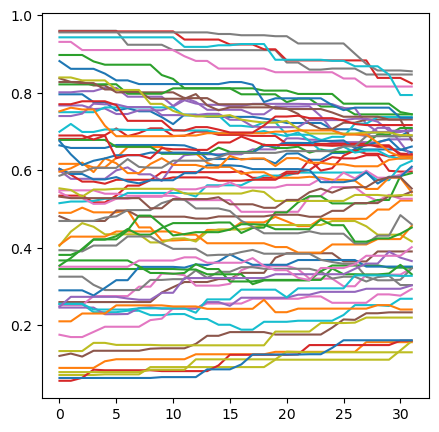

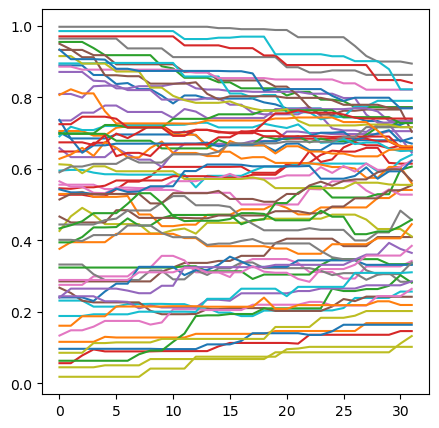

In [40]:
sim_coo.print_opinion_trajectory(X)
sim_coo.print_opinion_trajectory(X_from_X0_slow(X0_, mu1, edges, T1, edge_per_t1, N1).detach())

<AxesSubplot:>

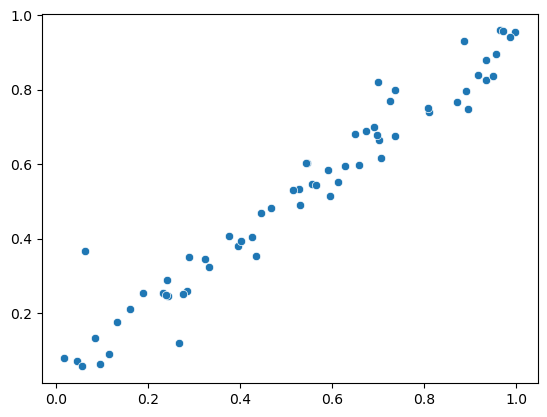

In [41]:
sns.scatterplot(x = X0_, y = X[0])

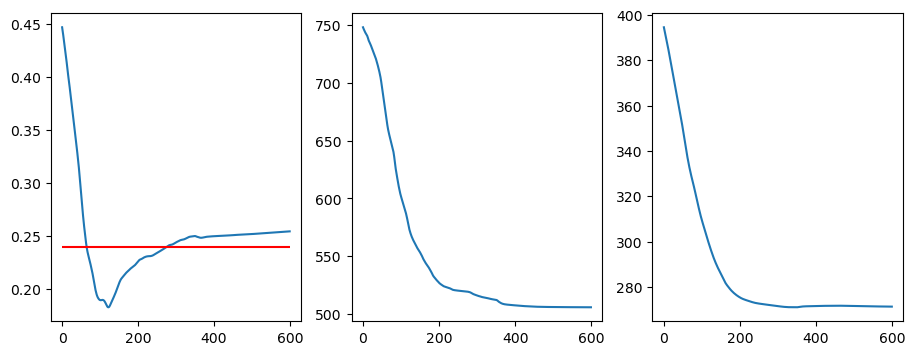

In [42]:
fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (11, 4))

axes[0].plot(history["epsilon"])
axes[0].hlines(y = epsilon1, xmin = 0, xmax = len(history["loss"]), color = "red")
axes[1].plot(history["loss edges"])
axes[2].plot(history["loss evidences"])

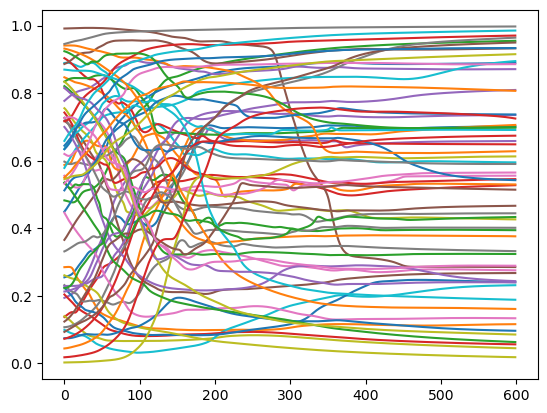

In [43]:
fig, axes = plt.subplots()

axes.plot(torch.cat([t[:, None] for t in history["X0"]], dim = 1).T.detach())

fig.show()